# Experiment 1 - Damage Score Estimation with Optical + SAR


## Objective
Estimate per-building damage class using pre/post optical + SAR imagery and a machine learning classifier.

In [1]:
#@title 1. Install Dependencies
# Install necessary libraries (if not already in Colab)
!pip install geopandas rasterio scikit-learn shapely pyproj tqdm

# === Mount your Google Drive if running in Colab ===
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 99.1 MB/s eta 0:00:00
Mounted at /content/drive


In [18]:
#@title 2. Load Building Footprints (GPKG) and Raster Metadata
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from pathlib import Path

# === Define file paths (update with your actual paths) ===
# Example paths — please replace with yours
gpkg_path = '/content/drive/MyDrive/raw_data/Updated Labled Buildings.gpkg'
optical_pre_path = '/content/drive/MyDrive/raw_data/planet/planet_aug2023/composite.tif'
optical_post_path = '/content/drive/MyDrive/raw_data/planet/planet_feb2025/composite.tif'
sar_pre_path = "/content/drive/MyDrive/raw_data/sar/SAR_VV_Gaza_2023_08_02.tif"
sar_post_path = "/content/drive/MyDrive/raw_data/sar/SAR_VV_Gaza_2025_02_18.tif"

# === Load GPKG ===
buildings_gdf = gpd.read_file(gpkg_path)
print(f"Loaded {len(buildings_gdf)} buildings")

# === Check the first few records ===
buildings_gdf.head()


Loaded 335498 buildings


,id,addr:city,building,layer,zone,name,name:ar,name:en,shop,amenity,...,Main_Damage_Site_Class_9_sum,Main_Damage_Site_Class_9_mean,Main_Damage_Site_Class_9_median,Main_Damage_Site_Class_9_stddev,Main_Damage_Site_Class_9_minority,Main_Damage_Site_Class_9_majority,Main_Damage_Site_Class_9_q1,Main_Damage_Site_Class_9_q3,Main_Damage_Site_Class_9_iqr,geometry
0,29684904,Rafah,yes,1,Z1,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((34.25464 31.24647, 34.25563 31.24724..."
1,29684943,Rafah,yes,None,Z1,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((34.2542 31.24751, 34.25465 31.24785,..."
2,29727198,None,yes,None,Z1,None,None,None,None,None,...,6.0,3.0,3.0,1.0,2.0,2.0,2.0,4.0,2.0,"POLYGON ((34.2531 31.28428, 34.25322 31.28434,..."
3,41312804,None,yes,None,Z1,مركز رفح التجاري,مركز رفح التجاري,Rafah Trade Center,None,None,...,3.0,3.0,3.0,0.0,3.0,3.0,3.0,3.0,0.0,"POLYGON ((34.25303 31.28242, 34.25325 31.28216..."
4,41312981,None,yes,None,Z1,Balbula,ورشة بلبولة لتصليح السيارات,None,car_repair,None,...,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,"POLYGON ((34.25896 31.28396, 34.25923 31.28374..."


In [ ]:
#@title 3. Reproject Buildings to Master Raster CRS
# === Load one raster to get its CRS ===
with rasterio.open(optical_pre_path) as src:
    raster_crs = src.crs
    print("Raster CRS:", raster_crs)

# === Reproject buildings to match raster CRS ===
if buildings_gdf.crs != raster_crs:
    buildings_gdf = buildings_gdf.to_crs(raster_crs)
    print("Reprojected buildings to match raster CRS.")
else:
    print("Building CRS already matches raster.")

# Check
buildings_gdf.head(1)

Raster CRS: EPSG:32636
Reprojected buildings to match raster CRS.


,id,addr:city,building,layer,zone,name,name:ar,name:en,shop,amenity,...,Main_Damage_Site_Class_9_sum,Main_Damage_Site_Class_9_mean,Main_Damage_Site_Class_9_median,Main_Damage_Site_Class_9_stddev,Main_Damage_Site_Class_9_minority,Main_Damage_Site_Class_9_majority,Main_Damage_Site_Class_9_q1,Main_Damage_Site_Class_9_q3,Main_Damage_Site_Class_9_iqr,geometry
0,29684904,Rafah,yes,1,Z1,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((619470.716 3457596.219, 619564.507 3..."


In [ ]:
#@title 4.A Extract Raster Features per Building
import numpy as np
from rasterio.mask import mask
from shapely.geometry import mapping
from tqdm import tqdm

# Helper to extract mean pixel values from a raster for a geometry
def extract_mean_raster_values(raster_path, gdf, prefix):
    with rasterio.open(raster_path) as src:
        out_crs = src.crs
        band_count = src.count
        features = []

        for geom in tqdm(gdf.geometry, desc=f"Extracting from {prefix}"):
            try:
                out_image, _ = mask(src, [mapping(geom)], crop=True)
                # Masked pixels = NaNs
                masked = np.ma.masked_array(out_image, out_image == src.nodata)
                stats = [masked[i].mean() for i in range(band_count)]
            except Exception:
                stats = [np.nan] * band_count

            features.append(stats)

        # Add each band as a separate column
        for i in range(band_count):
            gdf[f"{prefix}_band{i+1}_mean"] = [f[i] for f in features]

    return gdf

# Apply to each raster
buildings_gdf = extract_mean_raster_values(optical_pre_path, buildings_gdf, "opt_pre")
buildings_gdf = extract_mean_raster_values(optical_post_path, buildings_gdf, "opt_post")
buildings_gdf = extract_mean_raster_values(sar_pre_path, buildings_gdf, "sar_pre")
buildings_gdf = extract_mean_raster_values(sar_post_path, buildings_gdf, "sar_post")

# Preview updated columns
buildings_gdf[[col for col in buildings_gdf.columns if 'mean' in col]].head()

Extracting from sar_post: 100%|██████████| 335498/335498 [00:33<00:00, 9897.24it/s]


,Grouped_Damage_Classes_mean,Main_Damage_Site_Class_mean,Main_Damage_Site_Class_2_mean,Damage_Status_2_mean,Main_Damage_Site_Class_3_mean,Damage_Status_3_mean,Main_Damage_Site_Class_4_mean,Damage_Status_4_mean,Main_Damage_Site_Class_5_mean,Damage_Status_5_mean,...,opt_post_band1_mean,opt_post_band2_mean,opt_post_band3_mean,opt_post_band4_mean,opt_post_band5_mean,opt_post_band6_mean,opt_post_band7_mean,opt_post_band8_mean,sar_pre_band1_mean,sar_post_band1_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1555.236181,1802.663317,2255.378141,2315.949749,2996.255025,2822.35804,2871.339196,3102.316583,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2065.023256,2322.534884,2910.333333,3047.837209,3742.372093,3466.899225,3592.379845,3793.209302,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1375.990741,1645.722222,1792.925926,2066.37037,2274.166667,2310.240741,2497.324074,2753.962963,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1247.542169,1509.307229,1633.692771,1897.638554,2083.192771,2149.445783,2292.0,2523.23494,NaN,NaN
4,1.0,3.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,1079.795181,1339.060241,1444.746988,1684.120482,1858.53012,1901.228916,2028.506024,2326.915663,NaN,NaN


In [ ]:
#@title 4B. Extract SAR Raster Features per Building
from rasterio.mask import mask
from shapely.geometry import mapping
from tqdm import tqdm
import numpy as np

def extract_mean_raster_values_sar(raster_path, gdf, prefix):
    with rasterio.open(raster_path) as src:
        band_count = src.count
        features = []

        # Reproject buildings to match SAR raster CRS
        gdf_proj = gdf.to_crs(src.crs)

        for geom in tqdm(gdf_proj.geometry, desc=f"Extracting SAR from {prefix}"):
            try:
                out_image, _ = mask(src, [mapping(geom)], crop=True)
                # Compute mean ignoring NaNs
                stats = [np.nanmean(out_image[i]) for i in range(band_count)]
            except Exception:
                stats = [np.nan] * band_count

            features.append(stats)

        # Add SAR band stats back to original GDF
        for i in range(band_count):
            gdf[f"{prefix}_band{i+1}_mean"] = [f[i] for f in features]

    return gdf

# Apply SAR extraction only
buildings_gdf = extract_mean_raster_values_sar(sar_pre_path, buildings_gdf, "sar_pre")
buildings_gdf = extract_mean_raster_values_sar(sar_post_path, buildings_gdf, "sar_post")

Extracting SAR from sar_post: 100%|██████████| 335498/335498 [03:18<00:00, 1690.42it/s]


In [ ]:
#@title 4C. Save updated `buildings_gdf` to Google Drive (with SAR features)
out_gpkg_path = "/content/drive/MyDrive/damage_features_buildings_updated.gpkg"
out_csv_path = "/content/drive/MyDrive/damage_features_buildings_updated.csv"

# Save as GeoPackage
buildings_gdf.to_file(out_gpkg_path, driver='GPKG')
print(f"GeoPackage saved to: {out_gpkg_path}")

# Save as CSV
buildings_gdf.drop(columns='geometry').to_csv(out_csv_path, index=False)
print(f"CSV saved to: {out_csv_path}")


GeoPackage saved to: /content/drive/MyDrive/damage_features_buildings_updated.gpkg
CSV saved to: /content/drive/MyDrive/damage_features_buildings_updated.csv


In [ ]:
#@title 5. Reload updated GPKG and compute delta features
import geopandas as gpd
import pandas as pd

# === Load the updated GeoPackage with SAR features ===
updated_gpkg_path = "/content/drive/MyDrive/damage_features_buildings_updated.gpkg"
buildings_gdf = gpd.read_file(updated_gpkg_path)
print(f"Reloaded buildings_gdf with {len(buildings_gdf)} records")

# === Convert all relevant band columns to numeric ===
for col in buildings_gdf.columns:
    if '_band' in col and '_mean' in col:
        buildings_gdf[col] = pd.to_numeric(buildings_gdf[col], errors='coerce')

# === Identify band counts dynamically ===
optical_band_count = len([col for col in buildings_gdf.columns if col.startswith("opt_pre_band")])
sar_band_count = len([col for col in buildings_gdf.columns if col.startswith("sar_pre_band")])

# === Compute delta features for optical ===
for i in range(optical_band_count):
    pre_col = f"opt_pre_band{i+1}_mean"
    post_col = f"opt_post_band{i+1}_mean"
    delta_col = f"opt_delta_band{i+1}"
    buildings_gdf[delta_col] = buildings_gdf[post_col] - buildings_gdf[pre_col]

# === Compute delta features for SAR ===
for i in range(sar_band_count):
    pre_col = f"sar_pre_band{i+1}_mean"
    post_col = f"sar_post_band{i+1}_mean"
    delta_col = f"sar_delta_band{i+1}"
    buildings_gdf[delta_col] = buildings_gdf[post_col] - buildings_gdf[pre_col]

# === Show preview of new delta columns ===
delta_cols = [col for col in buildings_gdf.columns if "delta" in col]
buildings_gdf[delta_cols].head()

Reloaded buildings_gdf with 335498 records


,opt_delta_band1,opt_delta_band2,opt_delta_band3,opt_delta_band4,opt_delta_band5,opt_delta_band6,opt_delta_band7,opt_delta_band8,sar_delta_band1
0,-382.513819,-630.967337,-478.638191,-759.996231,-456.824121,-879.939698,-846.800251,-842.089196,-0.070081
1,-249.465116,-548.705426,-369.852713,-569.511628,-247.573643,-668.023256,-548.658915,-530.224806,0.324137
2,-1221.046296,-1435.703704,-1469.925926,-1429.379630,-1411.277778,-1581.351852,-1357.851852,-1136.916667,1.080373
3,-573.060241,-664.897590,-699.849398,-636.843373,-622.379518,-730.421687,-580.060241,-428.325301,-0.658950
4,-443.493976,-533.554217,-614.493976,-651.216867,-649.722892,-736.506024,-601.855422,-532.819277,2.556299


In [ ]:
#@title 6. Prepare training data with 4 target classes
from sklearn.model_selection import train_test_split

# Define the 4-class mapping
valid_classes = [1, 2, 3, 4]
label_col = "Main_Damage_Site_Class_9_majority"

# Filter features
feature_cols = [col for col in buildings_gdf.columns if "delta" in col]

# Clean + filter
ml_df = buildings_gdf[feature_cols + [label_col]].dropna()
ml_df[label_col] = ml_df[label_col].astype(int)

# Keep only 1–4 labels
ml_df = ml_df[ml_df[label_col].isin(valid_classes)]

# Prepare input/output
X = ml_df[feature_cols]
y = ml_df[label_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training samples:", len(X_train), "| Testing samples:", len(X_test))
print("Class distribution (train):\n", y_train.value_counts())


Training samples: 85521 | Testing samples: 36652
Class distribution (train):
 Main_Damage_Site_Class_9_majority
3    33344
1    29125
4    12047
2    11005
Name: count, dtype: int64


Classification Report:

              precision    recall  f1-score   support

           1      0.567     0.629     0.596     12483
           2      0.304     0.027     0.050      4716
           3      0.495     0.757     0.598     14290
           4      0.343     0.033     0.060      5163

    accuracy                          0.518     36652
   macro avg      0.427     0.362     0.326     36652
weighted avg      0.473     0.518     0.451     36652



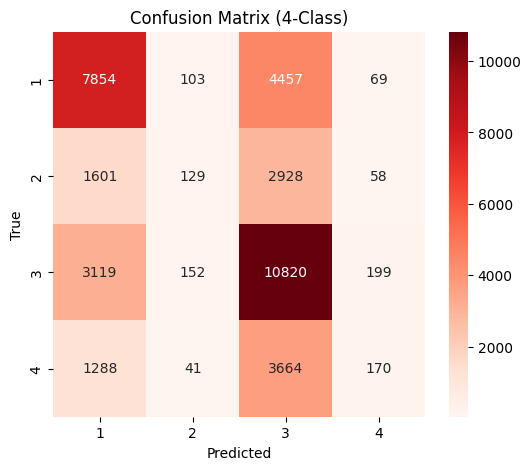

In [ ]:
#@title 7. Train and Evaluate Random Forest (4-class version)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # still useful in case class distribution is skewed
)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

# Confusion Matrix
labels = sorted(y_train.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (4-Class)")
plt.show()

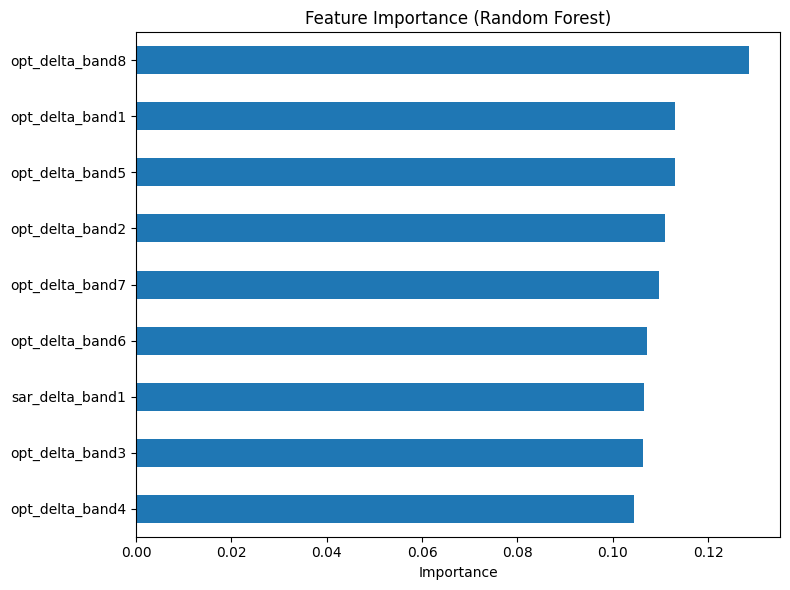

In [ ]:
#@title 8. Feature Importance from Random Forest
import pandas as pd
import numpy as np

# Get feature importances
importances = rf_model.feature_importances_
feature_ranks = pd.Series(importances, index=X_train.columns).sort_values(ascending=True)

# Plot
plt.figure(figsize=(8, 6))
feature_ranks.plot(kind='barh')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
#@title 9. XGBoost for Damage Classification
!pip install xgboost --quiet

 XGBoost Classification Report:

              precision    recall  f1-score   support

           1      0.573     0.627     0.599     12483
           2      0.347     0.007     0.015      4716
           3      0.495     0.783     0.607     14290
           4      0.411     0.025     0.047      5163

    accuracy                          0.523     36652
   macro avg      0.457     0.361     0.317     36652
weighted avg      0.491     0.523     0.449     36652



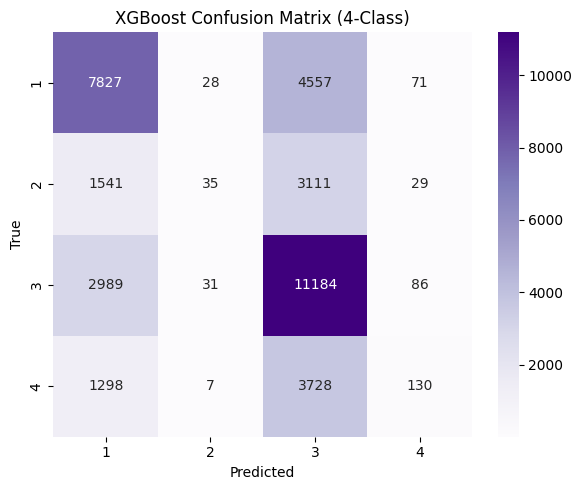

In [ ]:
#@title 9.1 Train and Evaluate XGBoost Classifier (with remapped labels)
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Remap labels 1–4 to 0–3 for XGBoost
label_map = {1: 0, 2: 1, 3: 2, 4: 3}
inv_label_map = {v: k for k, v in label_map.items()}

y_train_xgb = y_train.map(label_map)
y_test_xgb = y_test.map(label_map)

# Create and train the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='multi:softmax',
    num_class=4  # Now correctly set for 0–3
)
xgb_model.fit(X_train, y_train_xgb)

# Predict and remap predictions back to original 1–4
y_pred_xgb = xgb_model.predict(X_test)
y_pred_final = pd.Series(y_pred_xgb).map(inv_label_map)

# Evaluation
print(" XGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_final, digits=3))

# Confusion Matrix
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred_final, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("XGBoost Confusion Matrix (4-Class)")
plt.tight_layout()
plt.show()


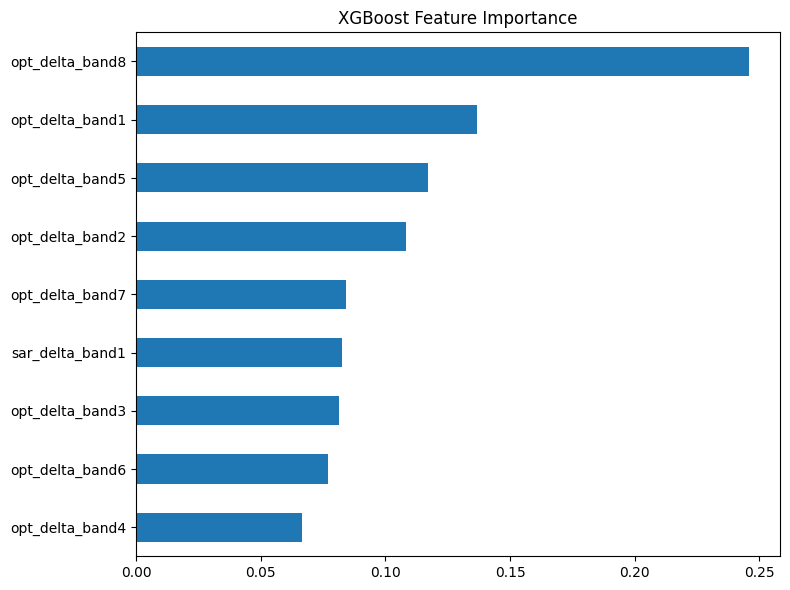

In [ ]:
#@title 9.2 Feature Importance from XGBoost
import pandas as pd

plt.figure(figsize=(8, 6))
pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh')
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


 Classification Report (3-Class):

              precision    recall  f1-score   support

           1      0.546     0.596     0.570       900
           2      0.425     0.417     0.421       900
           3      0.477     0.443     0.459       900

    accuracy                          0.485      2700
   macro avg      0.483     0.485     0.483      2700
weighted avg      0.483     0.485     0.483      2700



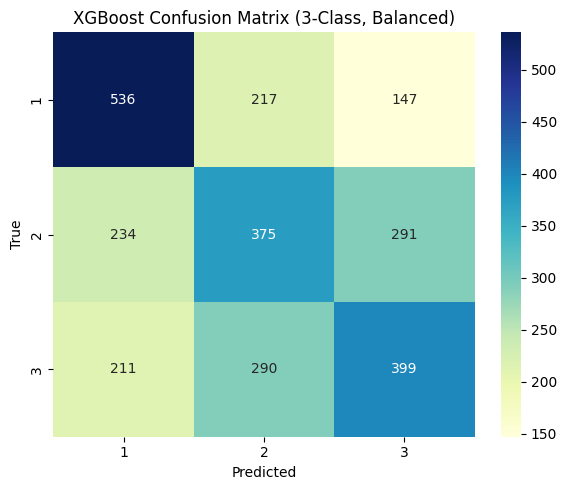

In [ ]:
#@title 10. Train XGBoost on Balanced 3-Class Dataset
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Collapse classes into 3 groups
label_map_3class = {1: 1, 2: 2, 3: 2, 4: 3}
inv_label_map_3class = {1: "Destroyed", 2: "Damaged", 3: "No Visible Damage"}

# Apply to full dataset
y_3class = y.map(label_map_3class)

# Optional: include VH if present
if 'sar_delta_band2' in buildings_gdf.columns:
    feature_cols.append('sar_delta_band2')

# Combine features and new labels
ml_df_3class = buildings_gdf[feature_cols].copy()
ml_df_3class["label"] = y_3class
ml_df_3class = ml_df_3class.dropna()

# Sample balanced data
balanced_df = ml_df_3class.groupby("label").sample(n=3000, random_state=42)

X_bal = balanced_df[feature_cols]
y_bal = balanced_df["label"]

# Map to 0-indexed labels
label_map = {1: 0, 2: 1, 3: 2}
inv_label_map = {v: k for k, v in label_map.items()}
y_bal_xgb = y_bal.map(label_map)

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal_xgb, stratify=y_bal_xgb, test_size=0.3, random_state=42)

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=3,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict and remap
y_pred = xgb_model.predict(X_test)
y_pred_final = pd.Series(y_pred).map(inv_label_map)
y_test_final = y_test.map(inv_label_map)

# Report
print(" Classification Report (3-Class):\n")
print(classification_report(y_test_final, y_pred_final, digits=3))

# Confusion Matrix
labels = sorted(y_test_final.unique())
cm = confusion_matrix(y_test_final, y_pred_final, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("XGBoost Confusion Matrix (3-Class, Balanced)")
plt.tight_layout()
plt.show()


In [ ]:
#@title 11. Add All Available Features
# List all delta-type features
delta_cols = [col for col in buildings_gdf.columns if 'delta' in col]

# (Optional) Check for geometric features
if 'geometry' in buildings_gdf.columns:
    buildings_gdf['area'] = buildings_gdf.geometry.area
    buildings_gdf['perimeter'] = buildings_gdf.geometry.length

# Final feature set
feature_cols = delta_cols + ['area', 'perimeter']
feature_cols = [col for col in feature_cols if col in buildings_gdf.columns]

print("Final feature columns:", feature_cols)

Final feature columns: ['opt_delta_band1', 'opt_delta_band2', 'opt_delta_band3', 'opt_delta_band4', 'opt_delta_band5', 'opt_delta_band6', 'opt_delta_band7', 'opt_delta_band8', 'sar_delta_band1', 'area', 'perimeter']


In [ ]:
#@title 12. Prepare Balanaced Training Dataset
# Rebuild dataset with new features
ml_df_all = buildings_gdf[feature_cols].copy()
ml_df_all['label'] = y.map(label_map_3class)  # 3-class

# Drop any missing data
ml_df_all = ml_df_all.dropna()

# Balanced sampling
balanced_df = ml_df_all.groupby('label').sample(n=3000, random_state=42)

X_bal = balanced_df[feature_cols]
y_bal = balanced_df['label']

In [ ]:
#@title 13. Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

# XGBoost expects zero-based labels
y_bal_zero = y_bal.map({1: 0, 2: 1, 3: 2})

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3),
    verbose=1,
    n_jobs=-1
)

grid.fit(X_bal, y_bal_zero)

print("Best parameters:", grid.best_params_)
print("Best F1 (macro):", grid.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:47:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Best F1 (macro): 0.5055010301981125


In [ ]:
#@title 14. Train Final Tuned XGBoost Model
final_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=42,
    max_depth=8,
    n_estimators=200,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8
)

final_model.fit(X_bal, y_bal_zero)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

Final Model Classification Report (3-Class):

              precision    recall  f1-score   support

           1      0.742     0.756     0.749       900
           2      0.677     0.736     0.705       900
           3      0.774     0.693     0.732       900

    accuracy                          0.728      2700
   macro avg      0.731     0.728     0.728      2700
weighted avg      0.731     0.728     0.728      2700



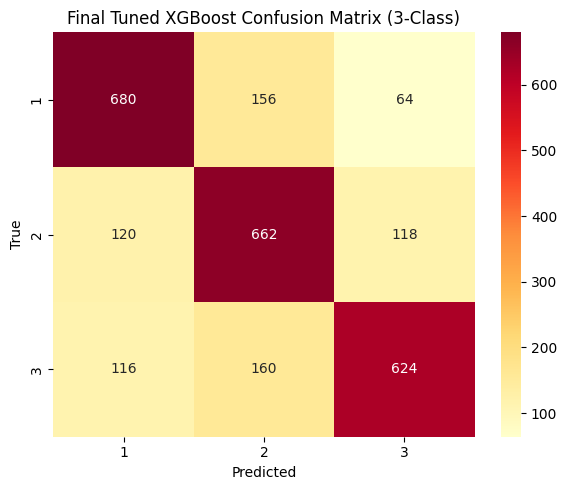

In [ ]:
#@title 14.1 Evaluate Final Tuned Model on Balanced Test Set
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Recreate train/test split using full balanced dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal_zero, stratify=y_bal_zero, test_size=0.3, random_state=42
)

# Predict
y_test_pred = final_model.predict(X_test)
y_test_final = pd.Series(y_test_pred).map(inv_label_map)  # 0–2 to 1–3
y_test_original = y_test.map(inv_label_map)

# Report
print("Final Model Classification Report (3-Class):\n")
print(classification_report(y_test_original, y_test_final, digits=3))

# Confusion Matrix
labels = sorted(y_test_original.unique())
cm = confusion_matrix(y_test_original, y_test_final, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Final Tuned XGBoost Confusion Matrix (3-Class)")
plt.tight_layout()
plt.show()


In [ ]:
#@title 14.2 Save Final XGBoost Model to Google Drive
import joblib
import shutil # Import the shutil module

model_path = "/content/final_xgboost_model.pkl"
drive_model_path = "/content/drive/MyDrive/final_xgboost_model.pkl"

# Save locally and copy to Drive
joblib.dump(final_model, model_path)
shutil.copy(model_path, drive_model_path)

print("Model saved to Google Drive at:")
print(drive_model_path)

Model saved to Google Drive at:
/content/drive/MyDrive/final_xgboost_model.pkl


In [ ]:
#@title 15. Load Saved Model from Google Drive
import joblib

model_path = "/content/drive/MyDrive/final_xgboost_model.pkl"
final_model = joblib.load(model_path)
print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
#@title 16. Load Buildings GeoPackage
import geopandas as gpd

gdf_path = "/content/drive/MyDrive/damage_features_buildings_updated.gpkg"
buildings_gdf = gpd.read_file(gdf_path)
print(f"Loaded {len(buildings_gdf)} buildings")

Loaded 335498 buildings


# R. Refinement

In [14]:
# Start with the true labeled GeoPackage
buildings_gdf = gpd.read_file("/content/drive/MyDrive/raw_data/Updated Labled Buildings.gpkg")

# Collapse labels
label_map_3class = {1: 1, 2: 2, 3: 2, 4: 3, 6: 3, 11: 3}
buildings_gdf['label_3class'] = buildings_gdf['Main_Damage_Site_Class_9_majority'].map(label_map_3class)

# Keep only labeled buildings
buildings_gdf = buildings_gdf[buildings_gdf['label_3class'].notna()].copy()

In [20]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from tqdm import tqdm
import numpy as np

# === Paths to SAR rasters ===
sar_vv_pre = "/content/drive/MyDrive/raw_data/sar/SAR_VV_Gaza_2023_08_02.tif"
sar_vv_post = "/content/drive/MyDrive/raw_data/sar/SAR_VV_Gaza_2025_02_18.tif"
sar_vh_pre = "/content/drive/MyDrive/raw_data/sar/SAR_VH_Gaza_2023_08.tif"
sar_vh_post = "/content/drive/MyDrive/raw_data/sar/SAR_VH_Gaza_2025_02.tif"

# Reproject buildings to match raster CRS
with rasterio.open(sar_vv_pre) as src:
    raster_crs = src.crs
buildings_gdf = buildings_gdf.to_crs(raster_crs)

# Function to compute per-building raster mean
def extract_band_mean(raster_path, gdf, feature_name):
    with rasterio.open(raster_path) as src:
        means = []
        for geom in tqdm(gdf.geometry, desc=f"Extracting {feature_name}"):
            try:
                out_image, _ = mask(src, [mapping(geom)], crop=True)
                data = out_image[0]
                data = data[data != src.nodata]
                mean_val = float(np.mean(data)) if data.size > 0 else np.nan
            except:
                mean_val = np.nan
            means.append(mean_val)
    gdf[feature_name] = means
    return gdf

# Apply to SAR
buildings_gdf = extract_band_mean(sar_vv_pre, buildings_gdf, "VV_pre")
buildings_gdf = extract_band_mean(sar_vv_post, buildings_gdf, "VV_post")
buildings_gdf = extract_band_mean(sar_vh_pre, buildings_gdf, "VH_pre")
buildings_gdf = extract_band_mean(sar_vh_post, buildings_gdf, "VH_post")

# Compute SAR deltas
buildings_gdf["VV_delta"] = buildings_gdf["VV_post"] - buildings_gdf["VV_pre"]
buildings_gdf["VH_delta"] = buildings_gdf["VH_post"] - buildings_gdf["VH_pre"]

Extracting VH_post: 100%|██████████| 335498/335498 [04:28<00:00, 1249.22it/s]


In [21]:
#@title R.1 Add Self Similarity Descriptors (SDD)

from sklearn.neighbors import NearestNeighbors

# Compute centroids
buildings_gdf['centroid'] = buildings_gdf.geometry.centroid
coords = np.array([[p.x, p.y] for p in buildings_gdf['centroid']])

#. Fit Nearest Neighbors (include self, skip later)
k = 8
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(coords)
_, indices = nbrs.kneighbors(coords)

# Define base features to apply SSD on
ssd_base_features = ['VV_delta', 'VH_delta']

# Loop and compute neighbor means
for feat in ssd_base_features:
    arr = buildings_gdf[feat].to_numpy()
    ssd_means = np.empty(len(arr))
    ssd_means[:] = np.nan

    for i in range(len(arr)):
        nbr_vals = arr[indices[i][1:]]  # skip self
        ssd_means[i] = np.nanmean(nbr_vals) if np.isfinite(nbr_vals).any() else np.nan

    buildings_gdf[f"{feat}_nbr_mean"] = ssd_means


In [23]:
# @title R.2 Prepare Training Data + Train XGBoost

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd # Import geopandas

# Load the buildings_gdf that includes the 'label_3class' column
# Assuming the correct file is the one used in cell JdA7oUByr139
gpkg_with_labels_path = "/content/drive/MyDrive/raw_data/Updated Labled Buildings.gpkg"
buildings_gdf = gpd.read_file(gpkg_with_labels_path)

# Collapse labels (re-apply the mapping in case the loaded file doesn't have it)
label_map_3class = {1: 1, 2: 2, 3: 2, 4: 3, 6: 3, 11: 3}
buildings_gdf['label_3class'] = buildings_gdf['Main_Damage_Site_Class_9_majority'].map(label_map_3class)

# Keep only labeled buildings
buildings_gdf = buildings_gdf[buildings_gdf['label_3class'].notna()].copy()

# Recompute SAR features and SSDs as they might have been overwritten
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from tqdm import tqdm
import numpy as np
from sklearn.neighbors import NearestNeighbors

# === Paths to SAR rasters ===
sar_vv_pre = "/content/drive/MyDrive/raw_data/sar/SAR_VV_Gaza_2023_08_02.tif"
sar_vv_post = "/content/drive/MyDrive/raw_data/sar/SAR_VV_Gaza_2025_02_18.tif"
sar_vh_pre = "/content/drive/MyDrive/raw_data/sar/SAR_VH_Gaza_2023_08.tif"
sar_vh_post = "/content/drive/MyDrive/raw_data/sar/SAR_VH_Gaza_2025_02.tif"

# Reproject buildings to match raster CRS
with rasterio.open(sar_vv_pre) as src:
    raster_crs = src.crs
buildings_gdf = buildings_gdf.to_crs(raster_crs)

# Function to compute per-building raster mean
def extract_band_mean(raster_path, gdf, feature_name):
    with rasterio.open(raster_path) as src:
        means = []
        for geom in tqdm(gdf.geometry, desc=f"Extracting {feature_name}"):
            try:
                out_image, _ = mask(src, [mapping(geom)], crop=True)
                data = out_image[0]
                data = data[data != src.nodata]
                mean_val = float(np.mean(data)) if data.size > 0 else np.nan
            except:
                mean_val = np.nan
            means.append(mean_val)
    gdf[feature_name] = means
    return gdf

# Apply to SAR
buildings_gdf = extract_band_mean(sar_vv_pre, buildings_gdf, "VV_pre")
buildings_gdf = extract_band_mean(sar_vv_post, buildings_gdf, "VV_post")
buildings_gdf = extract_band_mean(sar_vh_pre, buildings_gdf, "VH_pre")
buildings_gdf = extract_band_mean(sar_vh_post, buildings_gdf, "VH_post")

# Compute SAR deltas
buildings_gdf["VV_delta"] = buildings_gdf["VV_post"] - buildings_gdf["VV_pre"]
buildings_gdf["VH_delta"] = buildings_gdf["VH_post"] - buildings_gdf["VH_pre"]

# Compute centroids for SSD
buildings_gdf['centroid'] = buildings_gdf.geometry.centroid
coords = np.array([[p.x, p.y] for p in buildings_gdf['centroid']])

# Fit Nearest Neighbors (include self, skip later)
k = 8
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(coords)
_, indices = nbrs.kneighbors(coords)

# Define base features to apply SSD on
ssd_base_features = ['VV_delta', 'VH_delta']

# Loop and compute neighbor means
for feat in ssd_base_features:
    arr = buildings_gdf[feat].to_numpy()
    ssd_means = np.empty(len(arr))
    ssd_means[:] = np.nan

    for i in range(len(arr)):
        nbr_vals = arr[indices[i][1:]]  # skip self
        ssd_means[i] = np.nanmean(nbr_vals) if np.isfinite(nbr_vals).any() else np.nan

    buildings_gdf[f"{feat}_nbr_mean"] = ssd_means


# === Final features ===
feature_cols = ['VV_delta', 'VH_delta', 'VV_delta_nbr_mean', 'VH_delta_nbr_mean']

# Drop rows with missing labels or features
train_df = buildings_gdf.dropna(subset=feature_cols + ['label_3class']).copy()

# Build feature matrix and labels
X = train_df[feature_cols].apply(pd.to_numeric, errors='coerce')
y = train_df['label_3class'].astype(int)

# Encode labels: 1 → 0, 2 → 1, 3 → 2
label_encoder = {1: 0, 2: 1, 3: 2}
inv_label_encoder = {v: k for k, v in label_encoder.items()}
y_encoded = y.map(label_encoder)

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)

Extracting VH_post: 100%|██████████| 125773/125773 [01:39<00:00, 1263.60it/s]


In [24]:
#@title R.3 Train the model

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    objective='multi:softmax',
    num_class=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

 Classification Report (3-class):
              precision    recall  f1-score   support

           1      0.490     0.214     0.298     12484
           2      0.535     0.908     0.673     19007
           3      0.167     0.000     0.000      6241

    accuracy                          0.528     37732
   macro avg      0.397     0.374     0.324     37732
weighted avg      0.459     0.528     0.438     37732



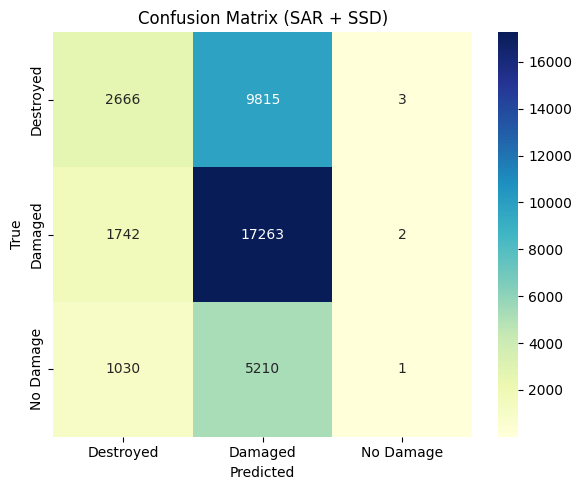

In [25]:
#@title R.4 Evaluate Performance

y_pred = xgb_model.predict(X_test)

print(" Classification Report (3-class):")
print(classification_report(
    y_test.map(inv_label_encoder),
    pd.Series(y_pred).map(inv_label_encoder),
    digits=3
))

cm = confusion_matrix(
    y_test.map(inv_label_encoder),
    pd.Series(y_pred).map(inv_label_encoder),
    labels=[1, 2, 3]
)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Destroyed', 'Damaged', 'No Damage'],
            yticklabels=['Destroyed', 'Damaged', 'No Damage'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (SAR + SSD)")
plt.tight_layout()
plt.show()


In [26]:
#@title R.5 Add optical delta + SSD features
def extract_mean_raster_values(raster_path, gdf, prefix):
    import rasterio
    from rasterio.mask import mask
    from shapely.geometry import mapping
    import numpy as np
    from tqdm import tqdm

    with rasterio.open(raster_path) as src:
        band_count = src.count
        means = []

        for geom in tqdm(gdf.geometry, desc=f"Extracting {prefix}"):
            try:
                out_image, _ = mask(src, [mapping(geom)], crop=True)
                arr = out_image.astype('float32')
                arr[arr == src.nodata] = np.nan
                stats = np.nanmean(arr, axis=(1, 2))  # mean per band
            except:
                stats = [np.nan] * band_count
            means.append(stats)

        # Assign new columns
        for i in range(band_count):
            gdf[f"{prefix}_band{i+1}"] = [m[i] for m in means]

    return gdf

optical_pre_path = "/content/drive/MyDrive/raw_data/planet/planet_aug2023/composite.tif"
optical_post_path = "/content/drive/MyDrive/raw_data/planet/planet_feb2025/composite.tif"

buildings_gdf = extract_mean_raster_values(optical_pre_path, buildings_gdf, "opt_pre")
buildings_gdf = extract_mean_raster_values(optical_post_path, buildings_gdf, "opt_post")

# Compute deltas
for i in range(1, 9):
    pre_col = f"opt_pre_band{i}"
    post_col = f"opt_post_band{i}"
    delta_col = f"opt_delta_band{i}"
    buildings_gdf[delta_col] = buildings_gdf[post_col] - buildings_gdf[pre_col]

# Define optical delta columns
opt_features = [f'opt_delta_band{i}' for i in range(1, 9)]

# Check if already extracted
if not all(col in buildings_gdf.columns for col in opt_features):
    raise ValueError("Missing optical deltas. Please extract them from optical imagery first.")

# Ensure numeric + imputed
for col in opt_features:
    buildings_gdf[col] = pd.to_numeric(buildings_gdf[col], errors='coerce')
    buildings_gdf[col] = buildings_gdf[col].fillna(buildings_gdf[col].median())

Extracting opt_post: 100%|██████████| 125773/125773 [00:18<00:00, 6825.82it/s]


In [27]:
#@title R.6 Compute SSD for Optical Delta Features
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Reuse centroids and neighbor indices (or recompute if needed)
buildings_gdf['centroid'] = buildings_gdf.geometry.centroid
coords = np.array([[p.x, p.y] for p in buildings_gdf['centroid']])
nbrs = NearestNeighbors(n_neighbors=9, algorithm='auto').fit(coords)
_, indices = nbrs.kneighbors(coords)

# Features to compute SSD on
opt_features = [f'opt_delta_band{i}' for i in range(1, 9)]

# Compute SSDs
for feat in opt_features:
    arr = buildings_gdf[feat].to_numpy()
    ssd_means = np.empty(len(arr))
    ssd_means[:] = np.nan
    for i in range(len(arr)):
        nbr_vals = arr[indices[i][1:]]  # skip self
        ssd_means[i] = np.nanmean(nbr_vals) if np.isfinite(nbr_vals).any() else np.nan
    buildings_gdf[f"{feat}_nbr_mean"] = ssd_means

In [28]:
#@title R.7 Define Full Feature Set
# SAR + Optical + SSDs
sar_features = ['VV_delta', 'VH_delta']
opt_features = [f'opt_delta_band{i}' for i in range(1, 9)]
ssd_features = [f"{f}_nbr_mean" for f in sar_features + opt_features]

# Full feature list
feature_cols = sar_features + opt_features + ssd_features

In [29]:
# Required imports
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import numpy as np
from tqdm import tqdm

def extract_optical_bands(raster_path, gdf, prefix):
    with rasterio.open(raster_path) as src:
        band_count = src.count
        values = []

        for geom in tqdm(gdf.geometry, desc=f"Extracting {prefix}"):
            try:
                out_image, _ = mask(src, [mapping(geom)], crop=True)
                arr = out_image.astype('float32')
                arr[arr == src.nodata] = np.nan
                stats = np.nanmean(arr, axis=(1, 2))  # mean per band
            except:
                stats = [np.nan] * band_count
            values.append(stats)

        # Add bands to gdf
        for i in range(band_count):
            gdf[f"{prefix}_band{i+1}"] = [v[i] for v in values]

    return gdf

In [30]:
optical_pre_path = "/content/drive/MyDrive/raw_data/planet/planet_aug2023/composite.tif"
optical_post_path = "/content/drive/MyDrive/raw_data/planet/planet_feb2025/composite.tif"

# Reproject buildings if needed
with rasterio.open(optical_pre_path) as src:
    raster_crs = src.crs
buildings_gdf = buildings_gdf.to_crs(raster_crs)

# Extract means
buildings_gdf = extract_optical_bands(optical_pre_path, buildings_gdf, "opt_pre")
buildings_gdf = extract_optical_bands(optical_post_path, buildings_gdf, "opt_post")

# Compute deltas
for i in range(1, 9):
    buildings_gdf[f"opt_delta_band{i}"] = buildings_gdf[f"opt_post_band{i}"] - buildings_gdf[f"opt_pre_band{i}"]

Extracting opt_post: 100%|██████████| 125773/125773 [04:01<00:00, 521.61it/s]


In [31]:
#@title R.8 Compute SSD for Optical Deltas
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Make sure centroids are ready
buildings_gdf['centroid'] = buildings_gdf.geometry.centroid
coords = np.array([[p.x, p.y] for p in buildings_gdf['centroid']])

# Find 8 nearest neighbors (skip self)
nbrs = NearestNeighbors(n_neighbors=9, algorithm='auto').fit(coords)
_, indices = nbrs.kneighbors(coords)

# Compute SSDs for optical delta bands
opt_features = [f'opt_delta_band{i}' for i in range(1, 9)]

for feat in opt_features:
    arr = buildings_gdf[feat].to_numpy()
    ssd_means = np.empty(len(arr))
    ssd_means[:] = np.nan
    for i in range(len(arr)):
        nbr_vals = arr[indices[i][1:]]  # skip self
        ssd_means[i] = np.nanmean(nbr_vals) if np.isfinite(nbr_vals).any() else np.nan
    buildings_gdf[f"{feat}_nbr_mean"] = ssd_means

In [32]:
#@title R.9 Define Full Feature Set
# SAR + Optical + SSDs
sar_features = ['VV_delta', 'VH_delta']
opt_features = [f'opt_delta_band{i}' for i in range(1, 9)]
ssd_features = [f"{f}_nbr_mean" for f in sar_features + opt_features]

feature_cols = sar_features + opt_features + ssd_features

In [33]:
#@title R.10 Prepare Data and Train XGBoost
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Clean + drop rows with missing label or features
train_df = buildings_gdf.dropna(subset=feature_cols + ['label_3class']).copy()
X = train_df[feature_cols].apply(pd.to_numeric, errors='coerce')
y = train_df['label_3class'].astype(int)

# Encode: 1 → 0, 2 → 1, 3 → 2
label_encoder = {1: 0, 2: 1, 3: 2}
inv_label_encoder = {v: k for k, v in label_encoder.items()}
y_encoded = y.map(label_encoder)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    objective='multi:softmax',
    num_class=3,
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

 Final Classification Report:
              precision    recall  f1-score   support

           1      0.625     0.559     0.591     12482
           2      0.608     0.833     0.703     19007
           3      0.477     0.041     0.075      6240

    accuracy                          0.611     37729
   macro avg      0.570     0.478     0.456     37729
weighted avg      0.592     0.611     0.562     37729



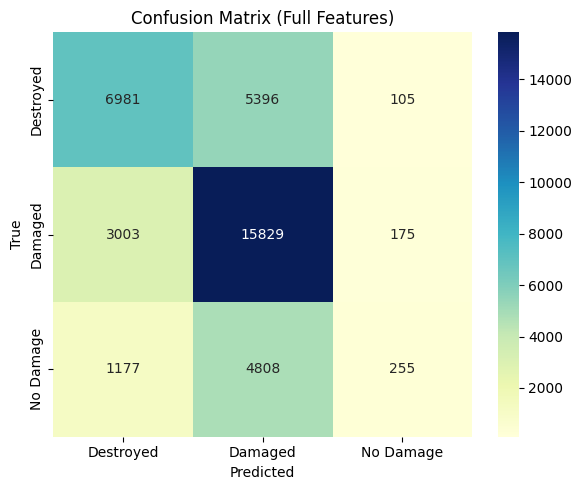

In [34]:
#@title R.11 Evaluate
y_pred = xgb_model.predict(X_test)

print(" Final Classification Report:")
print(classification_report(
    y_test.map(inv_label_encoder),
    pd.Series(y_pred).map(inv_label_encoder),
    digits=3
))

# Confusion Matrix
cm = confusion_matrix(
    y_test.map(inv_label_encoder),
    pd.Series(y_pred).map(inv_label_encoder),
    labels=[1, 2, 3]
)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Destroyed', 'Damaged', 'No Damage'],
            yticklabels=['Destroyed', 'Damaged', 'No Damage'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Full Features)")
plt.tight_layout()
plt.show()


In [35]:
#@title R.12 Add Markov Random Field (MRF) Smoothing

import numpy as np
from collections import Counter

# Restrict coords to X (filtered training set)
coords_X = np.array([[geom.centroid.x, geom.centroid.y] for geom in buildings_gdf.loc[X.index].geometry])
nbrs = NearestNeighbors(n_neighbors=9).fit(coords_X)
_, indices_X = nbrs.kneighbors(coords_X)

# Remap predictions
raw_preds = xgb_model.predict(X)
mapped_preds = pd.Series(raw_preds).map(inv_label_encoder).to_numpy()

# Apply MRF smoothing
from collections import Counter
smoothed_preds = []
for i, row in enumerate(indices_X):
    neighbor_preds = mapped_preds[row[1:]]  # exclude self
    vote = Counter(neighbor_preds)
    vote[mapped_preds[i]] += 1  # own prediction weighted
    smoothed_preds.append(vote.most_common(1)[0][0])

# Save smoothed result
buildings_gdf.loc[X.index, 'predicted_damage_class_mrf'] = smoothed_preds

 MRF-Smoothened Classification Report:
              precision    recall  f1-score   support

           1      0.656     0.543     0.594     41608
           2      0.600     0.860     0.707     63355
           3      0.684     0.015     0.029     20799

    accuracy                          0.615    125762
   macro avg      0.646     0.473     0.443    125762
weighted avg      0.632     0.615     0.557    125762



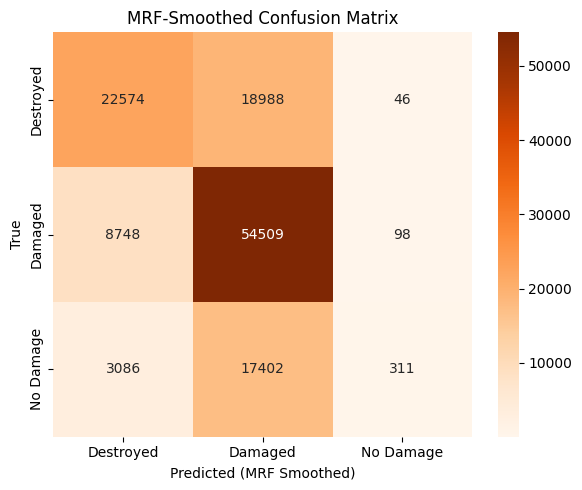

In [36]:
#@title R.13 Evaluate MRF Results
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure true labels are clean and aligned
y_true = buildings_gdf.loc[X.index, 'label_3class'].astype(float).dropna().astype(int)

# Align predictions too
y_pred_mrf_series = pd.Series(smoothed_preds, index=y_true.index)

print(" MRF-Smoothened Classification Report:")
print(classification_report(y_true, y_pred_mrf_series, digits=3))

cm = confusion_matrix(y_true, y_pred_mrf_series, labels=[1, 2, 3])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Destroyed', 'Damaged', 'No Damage'],
            yticklabels=['Destroyed', 'Damaged', 'No Damage'])
plt.xlabel("Predicted (MRF Smoothed)")
plt.ylabel("True")
plt.title("MRF-Smoothed Confusion Matrix")
plt.tight_layout()
plt.show()


# Model Optimization Strategies

In [37]:
#@title MO.1 Prepare Data for U-Net Segmentation

import os
import rasterio
import geopandas as gpd
import numpy as np
from rasterio import features
from shapely.geometry import box
from tqdm import tqdm

# === CONFIGURATION ===
# Paths to rasters (must be aligned and same resolution)
sar_vv_pre = "/content/drive/MyDrive/raw_data/sar/SAR_VV_Gaza_2023_08_02.tif"
sar_vv_post = "/content/drive/MyDrive/raw_data/sar/SAR_VV_Gaza_2025_02_18.tif"
sar_vh_pre = "/content/drive/MyDrive/raw_data/sar/SAR_VH_Gaza_2023_08.tif"
sar_vh_post = "/content/drive/MyDrive/raw_data/sar/SAR_VH_Gaza_2025_02.tif"

optical_pre = "/content/drive/MyDrive/raw_data/planet/planet_aug2023/composite.tif"
optical_post = "/content/drive/MyDrive/raw_data/planet/planet_feb2025/composite.tif"


buildings_gpkg = "/content/drive/MyDrive/raw_data/Updated Labled Buildings.gpkg"
label_column = "Main_Damage_Site_Class_9_majority"

output_dir = "/content/unet_dataset"
tile_size = 256
os.makedirs(output_dir, exist_ok=True)

# === 1. Load and align rasters ===
def stack_rasters(raster_paths):
    arrays = []
    shapes = []
    meta = None
    for path in raster_paths:
        with rasterio.open(path) as src:
            data = src.read(1)
            shapes.append(data.shape)
            if meta is None:
                meta = src.meta.copy()
            arrays.append(data)

    # Find smallest common shape
    min_height = min(shape[0] for shape in shapes)
    min_width = min(shape[1] for shape in shapes)

    cropped_arrays = [arr[:min_height, :min_width] for arr in arrays]
    stacked = np.stack(cropped_arrays, axis=0)
    meta.update({"height": min_height, "width": min_width})
    return stacked, meta

input_stack, meta = stack_rasters([
    sar_vv_post, sar_vv_pre,
    sar_vh_post, sar_vh_pre,
    optical_post, optical_pre
])

meta.update({"count": input_stack.shape[0]})

# === 2. Load buildings and rasterize labels ===
buildings = gpd.read_file(buildings_gpkg)
label_map = {1: 1, 2: 2, 3: 2, 4: 3, 6: 3, 11: 3}
buildings["label"] = buildings[label_column].map(label_map)

mask = features.rasterize(
    ((geom, value) for geom, value in zip(buildings.geometry, buildings["label"])),
    out_shape=(meta["height"], meta["width"]),
    transform=meta["transform"],
    fill=0,
    dtype="uint8"
)

# === 3. Tile generator ===
def generate_tiles(image, mask, size, stride):
    h, w = image.shape[1:]
    for y in range(0, h - size + 1, stride):
        for x in range(0, w - size + 1, stride):
            img_tile = image[:, y:y+size, x:x+size]
            msk_tile = mask[y:y+size, x:x+size]
            yield img_tile, msk_tile, x, y

# === 4. Export tiles ===
count = 0
for img_tile, msk_tile, x, y in tqdm(generate_tiles(input_stack, mask, tile_size, tile_size)):
    if np.all(msk_tile == 0):
        continue
    img_path = os.path.join(output_dir, f"tile_{count:05d}.tif")
    mask_path = os.path.join(output_dir, f"tile_{count:05d}_mask.tif")

    with rasterio.open(img_path, "w", driver="GTiff",
                       height=tile_size, width=tile_size, count=input_stack.shape[0],
                       dtype="float32", transform=meta["transform"], crs=meta["crs"]) as dst:
        dst.write(img_tile)

    with rasterio.open(mask_path, "w", driver="GTiff",
                       height=tile_size, width=tile_size, count=1,
                       dtype="uint8", transform=meta["transform"], crs=meta["crs"]) as dst:
        dst.write(msk_tile, 1)
    count += 1

print(f" Exported {count} labeled tiles to {output_dir}")

272it [00:00, 509.41it/s]

 Exported 88 labeled tiles to /content/unet_dataset


In [38]:
# MO.2: U-Net Dataset Class (Adjusted for 6-channel Input)
!pip install -q segmentation-models-pytorch
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import rasterio
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import segmentation_models_pytorch as smp

class DamageSegmentationDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.tiles = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif") and "_mask" not in f])
        self.transform = transform

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.tiles[idx])
        mask_path = img_path.replace(".tif", "_mask.tif")

        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)
            assert image.shape[0] == 6, f"Expected 6 channels, got {image.shape[0]}"
            image = (image - image.mean()) / (image.std() + 1e-8)
            image = np.nan_to_num(image, nan=0.0, posinf=0.0, neginf=0.0)

        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.int64)
            mask[~np.isin(mask, [1, 2, 3])] = 0
            mask = mask - 1
            mask[mask < 0] = 255

        return torch.from_numpy(image), torch.from_numpy(mask)

# Define U-Net with Pretrained Encoder (ResNet34, 6 bands)
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=6,
    classes=3,
)

# Load Dataset
dataset = DamageSegmentationDataset("/content/unet_dataset")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Setup training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
weights = torch.tensor([1.0, 1.2, 1.5], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=255)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Training loop
for epoch in range(20):
    model.train()
    total_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, masks)
        if torch.isnan(loss):
            print(" Skipping batch with NaN loss")
            continue
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        masks = masks.numpy()
        for p, t in zip(preds.flatten(), masks.flatten()):
            if t != 255:
                y_pred.append(p)
                y_true.append(t)

print("\n Final Evaluation Report:")
print(classification_report(y_true, y_pred, target_names=["Destroyed", "Damaged", "No Damage"]))


Epoch 1, Loss: 12.1719
Epoch 2, Loss: 10.4860
Epoch 3, Loss: 9.6896
Epoch 4, Loss: 9.2666
Epoch 5, Loss: 9.0407
Epoch 6, Loss: 8.7955
Epoch 7, Loss: 8.7424
Epoch 8, Loss: 8.7316
Epoch 9, Loss: 8.3906
Epoch 10, Loss: 8.3977
Epoch 11, Loss: 8.2242
Epoch 12, Loss: 8.0927
Epoch 13, Loss: 7.9859
Epoch 14, Loss: 7.8849
Epoch 15, Loss: 7.7548
Epoch 16, Loss: 7.6009
Epoch 17, Loss: 7.6068
Epoch 18, Loss: 7.5004
Epoch 19, Loss: 7.5344
Epoch 20, Loss: 7.4331

 Final Evaluation Report:
              precision    recall  f1-score   support

   Destroyed       0.37      0.15      0.22     15785
     Damaged       0.46      0.75      0.57     17324
   No Damage       0.15      0.08      0.11      4154

    accuracy                           0.42     37263
   macro avg       0.33      0.33      0.30     37263
weighted avg       0.39      0.42      0.37     37263



In [39]:
#@title MO.3 Weighted Sampling to Handle Class Imbalance
from torch.utils.data import WeightedRandomSampler

# Step 1: Calculate class frequencies
all_labels = []
for _, mask in dataset:
    labels = mask.numpy().flatten()
    labels = labels[labels != 255]  # exclude ignored
    all_labels.extend(labels.tolist())

label_counts = np.bincount(all_labels, minlength=3)
total = sum(label_counts)
class_weights = [total / (c + 1e-6) for c in label_counts]

# Step 2: Assign weights to samples
sample_weights = []
for _, mask in dataset:
    labels = mask.numpy().flatten()
    labels = labels[labels != 255]
    if len(labels) == 0:
        sample_weights.append(1.0)
        continue
    majority_class = np.bincount(labels).argmax()
    sample_weights.append(class_weights[majority_class])

# Step 3: Create sampler & DataLoader
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)

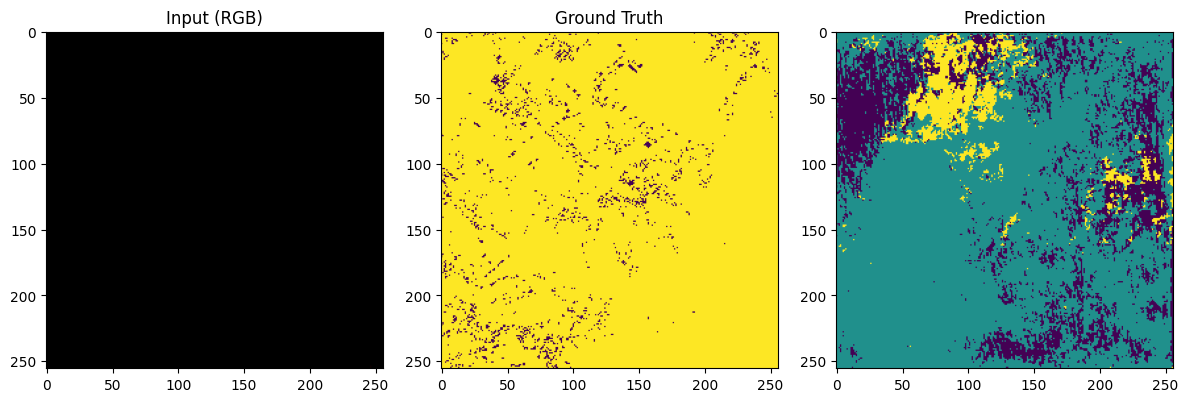

In [40]:
#@title MO.4 Visualize Model Predictions on Validation Set
import matplotlib.pyplot as plt

def visualize_prediction(model, dataset, index=0):
    model.eval()
    image, mask = dataset[index]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(output.squeeze(), dim=0).cpu()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image[:3].permute(1, 2, 0).cpu())
    axs[0].set_title("Input (RGB)")
    axs[1].imshow(mask.cpu(), cmap='viridis')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred.cpu(), cmap='viridis')
    axs[2].set_title("Prediction")
    plt.tight_layout()
    plt.show()

visualize_prediction(model, val_dataset, index=5)

In [41]:
#title MO.5 Additional Features Integration
with rasterio.open("/content/unet_dataset/tile_00001.tif") as src:
    print("Bands in tile:", src.count)  # Should reflect all features (6, 8, or 16)

Bands in tile: 6


# DeepLabV3+

In [2]:
#@title DL.1 Install and Imports

!pip install segmentation-models-pytorch --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
import rasterio
from sklearn.metrics import classification_report


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.5 MB/s eta 0:00:00


In [47]:
#@title DL.2 Export Full Feature Stack Tiles to Google Drive (Optimized)
import os
import rasterio
from rasterio.transform import from_origin
import numpy as np
from tqdm import tqdm

# === 1. Setup paths ===
output_dir = "/content/drive/MyDrive/full_feature_tiles"
os.makedirs(output_dir, exist_ok=True)

# === 2. Define the 20 features to export ===
feature_bands = [
    'opt_delta_band1', 'opt_delta_band2', 'opt_delta_band3', 'opt_delta_band4',
    'opt_delta_band5', 'opt_delta_band6', 'opt_delta_band7', 'opt_delta_band8',
    'VV_delta', 'VH_delta',
    'opt_delta_band1_nbr_mean', 'opt_delta_band2_nbr_mean', 'opt_delta_band3_nbr_mean', 'opt_delta_band4_nbr_mean',
    'opt_delta_band5_nbr_mean', 'opt_delta_band6_nbr_mean', 'opt_delta_band7_nbr_mean', 'opt_delta_band8_nbr_mean',
    'VV_delta_nbr_mean', 'VH_delta_nbr_mean'
]

# === 3. Export Settings ===
tile_size = 128  # pixels
res = 10         # meters per pixel
crs = buildings_gdf.crs

# Template metadata for raster tiles
transform = from_origin(0, 0, res, res)
meta_template = {
    "driver": "GTiff",
    "dtype": "float32",
    "count": len(feature_bands),
    "crs": crs,
    "width": tile_size,
    "height": tile_size,
    "transform": transform
}

# === 4. Sample a smaller labeled set to optimize disk/time ===
sampled_gdf = buildings_gdf.dropna(subset=['label_3class']).sample(n=3000, random_state=42)
print(f" Sampled {len(sampled_gdf)} labeled buildings for export.")

# === 5. Export each tile ===
exported = 0
for idx, row in tqdm(sampled_gdf.iterrows(), total=len(sampled_gdf), desc=" Exporting tiles"):
    try:
        tile = np.zeros((len(feature_bands), tile_size, tile_size), dtype=np.float32)
        for i, band in enumerate(feature_bands):
            val = row.get(band, np.nan)
            tile[i, :, :] = 0 if np.isnan(val) else val

        # Set tile location
        meta = meta_template.copy()
        meta["transform"] = from_origin(row.geometry.centroid.x, row.geometry.centroid.y, res, res)

        # Save image tile
        out_path = os.path.join(output_dir, f"tile_{idx}.tif")
        with rasterio.open(out_path, "w", **meta) as dst:
            dst.write(tile)

        # Save corresponding mask
        label = row.get("label_3class", 0)
        label = label if label in [1, 2, 3] else 0
        mask = np.full((tile_size, tile_size), label, dtype=np.uint8)
        mask_path = out_path.replace(".tif", "_mask.tif")

        with rasterio.open(mask_path, "w", driver="GTiff", height=tile_size, width=tile_size, count=1,
                           dtype="uint8", crs=crs, transform=meta["transform"]) as dst:
            dst.write(mask, 1)

        exported += 1

    except Exception as e:
        print(f" Skipping tile {idx} due to error: {e}")

print(f" Exported {exported} full-feature tiles to Google Drive at: {output_dir}")


 Sampled 3000 labeled buildings for export.


 Exporting tiles: 100%|██████████| 3000/3000 [01:24<00:00, 35.63it/s]

 Exported 3000 full-feature tiles to Google Drive at: /content/drive/MyDrive/full_feature_tiles


In [3]:
#@title DL.3 Dataset Loader (Full Feature Tiles from Google Drive)
import torch
from torch.utils.data import Dataset
import rasterio
import numpy as np
import os

class DeepLabDamageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.tiles = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif") and "_mask" not in f])

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.tiles[idx])
        mask_path = img_path.replace(".tif", "_mask.tif")

        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32)
            img = (img - img.mean()) / (img.std() + 1e-8)
            img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)

        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.int64)
            mask[~np.isin(mask, [1, 2, 3])] = 0
            mask = mask - 1
            mask[mask < 0] = 255

        return torch.from_numpy(img), torch.from_numpy(mask)


In [49]:
#@title DL.4 Define DeepLabV3+ Model
import segmentation_models_pytorch as smp
import torch.nn as nn

in_channels = 20  # 20 features in our stacked dataset
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=in_channels,
    classes=3,
)


In [52]:
#@title DL.5 Train DeepLabV3+ Model with GPU Monitoring
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from tqdm import tqdm
import time
import os

# Load dataset
dataset = DeepLabDamageDataset("/content/drive/MyDrive/full_feature_tiles")
train_len = int(0.8 * len(dataset))
train_ds, val_ds = random_split(dataset, [train_len, len(dataset) - train_len])
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=2, pin_memory=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f" Using device: {device}")

# Optimizer, loss, scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
weights = torch.tensor([1.0, 1.2, 1.5], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=255)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Training loop with monitoring
num_epochs = 20
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    loss_sum = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for imgs, masks in pbar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, masks)

        if torch.isnan(loss):
            print(" Skipping batch with NaN loss")
            continue

        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        pbar.set_postfix(loss=loss.item())

    scheduler.step(loss_sum)
    elapsed = time.time() - start_time
    print(f" Epoch {epoch+1:02d} completed | Loss: {loss_sum:.4f} | Time: {elapsed/60:.2f} min")

    # Log GPU usage every 5 epochs
    if epoch % 5 == 0 or epoch == num_epochs - 1:
        os.system("nvidia-smi")

print(" Training complete.")

 Using device: cuda


 Epoch 01 completed | Loss: 297.7270 | Time: 42.03 min


 Epoch 02 completed | Loss: 293.1276 | Time: 83.26 min


 Epoch 03 completed | Loss: 292.2902 | Time: 128.68 min


 Epoch 04 completed | Loss: 291.8147 | Time: 177.04 min


 Epoch 05 completed | Loss: 287.0259 | Time: 219.88 min


 Epoch 06 completed | Loss: 287.9490 | Time: 263.88 min


 Epoch 07 completed | Loss: 289.1655 | Time: 303.46 min


 Epoch 08 completed | Loss: 289.7147 | Time: 353.44 min


 Epoch 09 completed | Loss: 288.7729 | Time: 398.09 min


 Epoch 10 completed | Loss: 287.0494 | Time: 444.30 min


 Epoch 11 completed | Loss: 285.9818 | Time: 490.53 min


 Epoch 12 completed | Loss: 286.3340 | Time: 534.97 min


 Epoch 13 completed | Loss: 286.1160 | Time: 577.92 min


 Epoch 14 completed | Loss: 285.4505 | Time: 623.20 min


 Epoch 15 completed | Loss: 284.2722 | Time: 668.20 min


 Epoch 16 completed | Loss: 283.5744 | Time: 714.23 min


 Epoch 17 completed | Loss: 281.8654 | Time: 756.66 min


 Epoch 18 completed | Loss: 284.6587 | Time: 802.69 min


 Epoch 19 completed | Loss: 281.9264 | Time: 847.43 min


 Epoch 20 completed | Loss: 283.2830 | Time: 891.62 min
 Training complete.


In [53]:

#@title DL.6 Save DeepLabV3+ Model to Google Drive

model_drive_path = "/content/drive/MyDrive/deeplabv3plus_full_features.pth"

# Save the model state dictionary
torch.save(model.state_dict(), model_drive_path)

print(f"DeepLabV3+ model saved to Google Drive at: {model_drive_path}")


DeepLabV3+ model saved to Google Drive at: /content/drive/MyDrive/deeplabv3plus_full_features.pth


Fri Jun 27 14:40:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Evaluating DeepLabV3+: 100%|██████████| 13/13 [04:21<00:00, 20.14s/it]



📝 DeepLabV3+ Evaluation Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

   Destroyed      0.592     0.674     0.630    507904
     Damaged      0.607     0.818     0.697    786432
   No Damage      0.000     0.000     0.000    344064

    accuracy                          0.602   1638400
   macro avg      0.400     0.497     0.442   1638400
weighted avg      0.475     0.602     0.530   1638400



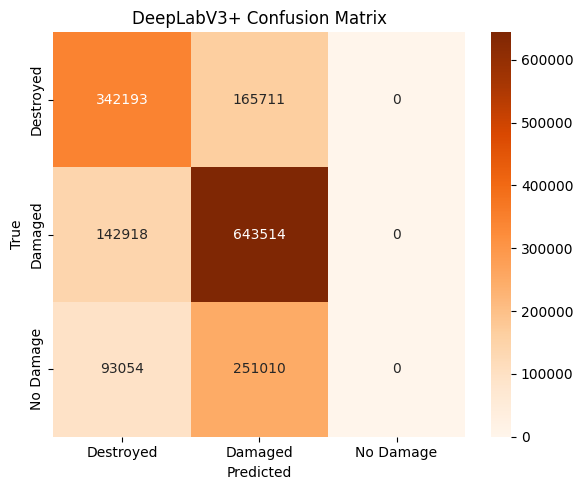

In [4]:
#@title DL.8 Evaluate Model Performance with Progress & GPU Monitoring
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split, Subset
import torch
import segmentation_models_pytorch as smp
from tqdm import tqdm
import numpy as np
import os
import rasterio # Import rasterio here

# === Define DeepLabDamageDataset class ===
class DeepLabDamageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.tiles = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif") and "_mask" not in f])

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.tiles[idx])
        mask_path = img_path.replace(".tif", "_mask.tif")

        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32)
            img = (img - img.mean()) / (img.std() + 1e-8)
            img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)

        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.int64)
            mask[~np.isin(mask, [1, 2, 3])] = 0
            mask = mask - 1
            mask[mask < 0] = 255

        return torch.from_numpy(img), torch.from_numpy(mask)


# === Check GPU Usage (Optional) ===
!nvidia-smi

# === Load dataset ===
dataset = DeepLabDamageDataset("/content/drive/MyDrive/full_feature_tiles")
train_len = int(0.8 * len(dataset))
train_ds, val_ds = random_split(dataset, [train_len, len(dataset) - train_len])

# Optional: Reduce validation set size for speed (e.g., 100 samples)
val_ds = Subset(val_ds, range(min(100, len(val_ds))))  # comment this line for full evaluation

val_loader = DataLoader(val_ds, batch_size=8, num_workers=2, pin_memory=True)

# === Reload model architecture ===
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=20,  # adjust if needed
    classes=3,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === Load saved model ===
model.load_state_dict(torch.load("/content/drive/MyDrive/deeplabv3plus_full_features.pth", map_location=device))

# === Evaluate ===
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, masks in tqdm(val_loader, desc="Evaluating DeepLabV3+"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        masks = masks.numpy()

        for p, t in zip(preds.flatten(), masks.flatten()):
            if t != 255:
                y_pred.append(p)
                y_true.append(t)

# === Report ===
target_names = ["Destroyed", "Damaged", "No Damage"]
print("\n DeepLabV3+ Evaluation Report:")
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DeepLabV3+ Confusion Matrix")
plt.tight_layout()
plt.show()

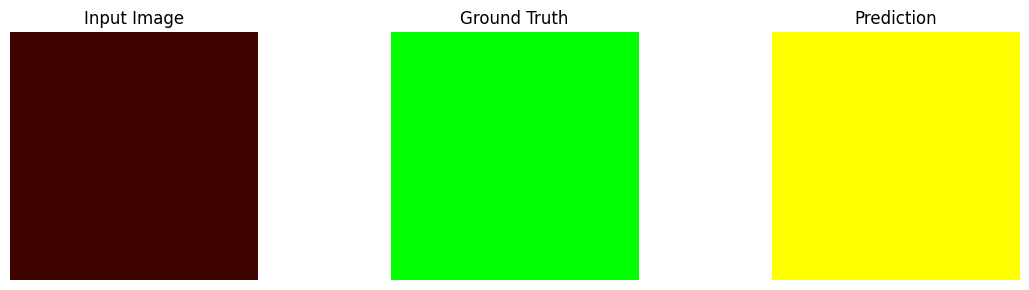

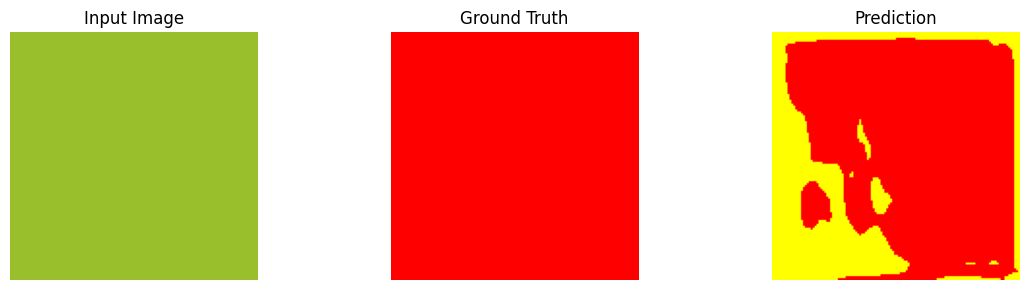

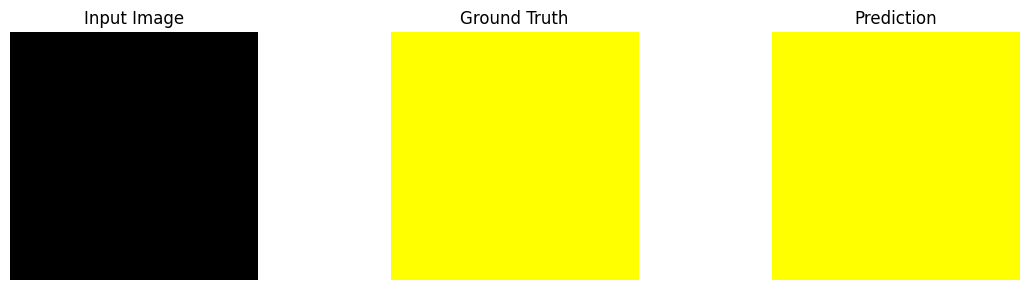

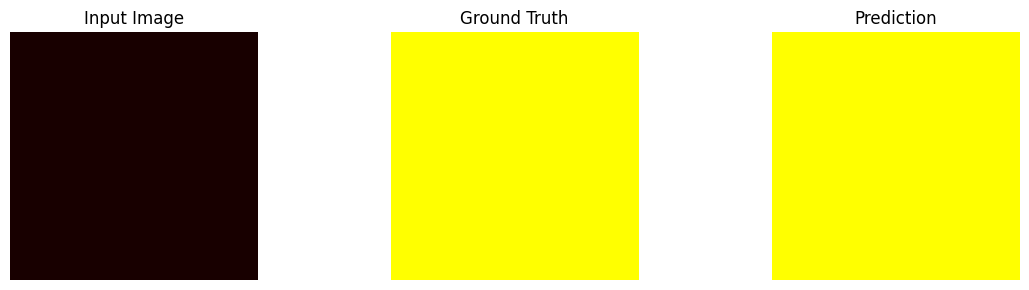

In [5]:
#@title DL.9 Visualize Predictions on Validation Set
import matplotlib.pyplot as plt
import numpy as np
import torch

# Class colormap (you can customize colors)
colors = {
    0: (1.0, 0.0, 0.0),   # Destroyed – Red
    1: (1.0, 1.0, 0.0),   # Damaged – Yellow
    2: (0.0, 1.0, 0.0),   # No Damage – Green
    255: (0.0, 0.0, 0.0), # Ignored – Black
}

def colorize_mask(mask):
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3))
    for k, color in colors.items():
        rgb[mask == k] = color
    return rgb

# Get 1 batch from validation set
model.eval()
imgs, masks = next(iter(val_loader))
imgs = imgs.to(device)

with torch.no_grad():
    outputs = model(imgs)
    preds = torch.argmax(outputs, dim=1).cpu()

# Plot predictions vs ground truth
n = min(4, imgs.size(0))  # show up to 4
for i in range(n):
    img = imgs[i].cpu().numpy()
    mask = masks[i].cpu().numpy()
    pred = preds[i].numpy()

    plt.figure(figsize=(12, 3))

    plt.subplot(1, 3, 1)
    img_vis = img[0:3] if img.shape[0] >= 3 else np.repeat(img[0:1], 3, axis=0)  # use 3-band subset for RGB
    plt.imshow(np.moveaxis(img_vis, 0, -1))
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(colorize_mask(mask))
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(colorize_mask(pred))
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
